In [1]:
import numpy as np 
import pandas as pd
import numpy.linalg as LA
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import matplotlib.patches as patches
import re

In [2]:
class Kmeans: 
    def __init__(self, X, k=3, maxiter=30): 
        self.assign, reps = self.lloyds(X, k, maxiter)
        self.gplotter(X, self.assign, reps)
#         print('final assignments:',self.assign)
        
    #ARGS: X - (n)x(d) matrix (n-#datapoints, d-dimension)
    #      k - # of groupings
    #      assign - n-vector, encodes to which cluster a given datapoint is assigned to (ex: assign[j] ==> i : jth
    #      datapoint belongs to ith cluster)
    #RETURN: reps - (k)x(d) matrix, stores vects representing optimal representatives for each of the k clusters
    #
    # gives optimal representatives for the given groupings, done so via component wise (0th axis) averaging 
    # across all vects in said grouping
    def opt_reps(self, X, k, weights, assign):   
        (n, d) = X.shape
        reps = np.zeros((k, d))
        for i in range(k):
            in_i = [j for j in range(n) if assign[j] == i]             
            weighted_sum = np.sum(weights[in_i, None] * X[in_i, :], axis=0)
            total_weight = np.sum(weights[in_i])
            reps[i, :] = weighted_sum / total_weight if total_weight != 0 else np.zeros(d)
        return reps


    #ARGS: X - (n)x(d) matrix (n-#datapoints, d-dimension)
    #      k - # of groupings
    #      reps - (k)x(d) matrix, stores vects representing optimal representatives for each of the k clusters
    #RETURN: assign - n-vector, encodes to which cluster a given datapoint is assigned to (ex: assign[j] ==> i : jth
    #        datapoint belongs to ith cluster)
    # gives optimal grouping for given representatives, done so via calculating dist. from single point to all possible
    # representatives, then assigning said point to grouping corresponding to representative of nearest distance.
    # also calculates "error" : the squared sum of distance between all points and their respective representatives
    def opt_clust(self, X, k, weights, reps):
        (n, d) = X.shape
        dist = np.zeros(n)
        assign = np.zeros(n, dtype=int)
        for j in range(n):
            dist_to_i = np.array([LA.norm(X[j,:] - reps[i,:]) for i in range(k)])
            assign[j] = np.argmin(dist_to_i)
            dist[j] = dist_to_i[assign[j]]
#         G = np.sum(weights * (dist ** 2))
#         print(f'score:{G}')
        return assign


    #ARGS: X - (n)x(d) matrix (n-#datapoints, d-dimension)
    #      k - # of groupings
    #RETURN: np array, (k)x(d), containing the initial guesses at representatives, as well as (n)x(1) np array giving
    # initial guesses at assignments of datapoints to said representatives
    # ensuring the plateau and bottom have respective representatives, as well as repeatability in grouping
    def init_reps_assign(self, X): 
        x = X[:,0]
        y = X[:,1]
        n,_ = X.shape
        assign = np.zeros(n)
        weights = np.zeros(n)
        
        #reps and assignments for the plateau region
        rough_plat_mask = y>.75
        rough_plat = X[rough_plat_mask]
        plat_rep_x = np.mean(rough_plat[:,0]) 
        plat = np.array([plat_rep_x, 1])
        assign[rough_plat_mask] = 0
        weights[rough_plat_mask] = 1 
        
        #reps and assignments for LHS
        LHS_mask = (~rough_plat_mask) & (x < 0)
        LHS_x_min = X[LHS_mask, 0].min()
        LHS_x_max = X[LHS_mask, 0].max()
        LHS_diff = LHS_x_max - LHS_x_min
        assign[LHS_mask] = 1

        # Interpolate weights for LHS from 0.5 to 1
        LHS_relative_positions = (X[LHS_mask, 0] - LHS_x_min) / LHS_diff
        weights[LHS_mask] = 0.25 + 1.25 * LHS_relative_positions  # Scale weights linearly from 0.5 to 1
        l = np.array([LHS_x_min + LHS_diff * 0.75, 0.5])  # Example choice for representative

        # Reps and assignments for RHS
        RHS_mask = (~rough_plat_mask) & (x > 0)
        RHS_x_min = X[RHS_mask, 0].min()
        RHS_x_max = X[RHS_mask, 0].max()
        RHS_diff = RHS_x_max - RHS_x_min
        assign[RHS_mask] = 2

        # Interpolate weights for RHS from 1 to 0.5
        RHS_relative_positions = (X[RHS_mask, 0] - RHS_x_min) / RHS_diff
        weights[RHS_mask] = 1.5 - 1.25 * RHS_relative_positions  # Scale weights linearly from 1 to 0.5
        r = np.array([RHS_x_min + RHS_diff * 0.25, 0.5])
        
        reps = np.stack((plat, l, r), axis = 0)
#         print(f'weights: {weights}')
#         self.gplotter(X, assign, reps)
        return reps, assign, weights 

    #ARGS: X - (n)x(d) matrix (n-#datapoints, d-dimension)
    #      k - # of groupings
    #      rng - random number generator 
    #RETURN: assign - n-vector, encodes to which cluster a given datapoint is assigned to (ex: assign[j] ==> i : jth
    #        datapoint belongs to ith cluster)
    # iterativly optimizes over cluster assignment as well as representative choice to carry out lloyd's algorithm
    def lloyds(self, X, k, maxiter):
        (n, d) = X.shape
        reps, assign, weights = self.init_reps_assign(X)
        for iter in range(maxiter):
            assign = self.opt_clust(X, k, weights, reps)
            reps = self.opt_reps(X, k, weights, assign)
#             self.gplotter(X, assign, reps)
        return assign, reps
    
    #plotter so user can determine if initial Roi is desireable
    def gplotter(self, data, grouping, reps): 
        reps_x = reps[:,0]
        reps_y = reps[:,1]
        pos = data[:,0]
        norm = data[:,1]
        plt.figure()
        plt.figure(figsize=(14, 4))
        plt.scatter(pos[1:-1], norm[1:-1], s=10, c=grouping[1:-1], cmap='cool')
        plt.scatter(reps_x,reps_y, color = 'black', label = 'representatives')
        for i in range(len(reps_x)):
            plt.annotate(f'({reps_x[i]:.3f}, {reps_y[i]:.3f})', (reps_x[i], reps_y[i]), textcoords="offset points", xytext=(0,10), ha='center')
        plt.xlabel('Deviation')
        plt.ylabel(f'Relative Dose')
        plt.legend()
        plt.show

In [12]:
class Band: 
    def __init__(self, name, data, orientation, k=3, m=.5):  
        #obtain the raw data from corresponding csv file 
        self.name = name
        self.orientation = orientation 
        self.raw_data = np.stack(data, axis=1)
        self.arr_raw = self.artifact_remover(self.raw_data, m)
        
        #remove any artifacts based on slope and do k-means on resulting data, then implement filter
        km = Kmeans(self.raw_data, k)
        self.o_roi_data = self.arr_raw[km.assign == 0, :]
    
    
    def LReg(self, roi_data): 
        x, y = roi_data[:,0].reshape(-1, 1), roi_data[:,1].reshape(-1, 1)
        reg = LinearRegression().fit(x,y)
        s = reg.score(x,y)
        m,b = reg.coef_, reg.intercept_
        y_pred = m * (x) + b 
        return m,b,y_pred,s
    
    
    
    #ARGS: allot_pct - data outside of this pct diff will not be included in the refined fit
    #RETURN: no return, initializes the centered refined roi attrbute
    # called iterativly to obtain an roi which is centered, has the artifacts removed, and includes desired points
    def refine(self, allot_pct = 3): 
        # get relavant vars according to og fit (oroi)(minus artifacts)####################
        x = self.arr_raw[:,0]              
        y = self.arr_raw[:,1]
        o_m, o_b, o_ypred, o_s = self.LReg(self.o_roi_data)
        
        # make pct cutoff according to og fit, giving refined ROI (r_roi)######################
        y_pred_full = o_m* x + o_b
        pct_diff = 100 * np.abs((y - y_pred_full) / y_pred_full)
        r_roi_mask = pct_diff.reshape(pct_diff.shape[1])<=allot_pct
        r_roi_data = self.arr_raw[r_roi_mask,:]
        
        #centers roi data then plots so user can verify that the roi is acceptable
        self.shift, rb, lb = self.center(r_roi_data)
        self.cent_arr_roi_data = np.stack(((r_roi_data[:,0] + self.shift), r_roi_data[:,1]), axis=1) 
        pos = self.cent_arr_roi_data[:,0]
        norm = self.cent_arr_roi_data[:,1]
        plt.figure()
        plt.figure(figsize=(14, 4))
        plt.scatter(pos, norm)
        plt.ylabel('Relative Dose')
        plt.xlabel('Deviation(field Space)')
        plt.title(f'Refined ROI ({allot_pct}% cutoff from crude fit) - {self.name}')
        
        
    def artifact_remover(self, rr, cutoff_m):  
        n = rr.shape[0]
        slope_int = np.zeros(n)
        for i in range(1, n-4): 
            l = i-1
            u = i+5
            reg_reg_m, _, _, _ = self.LReg(rr[l:u, :])
#             print(reg_reg_m)
            if np.abs(reg_reg_m) >= cutoff_m: 
                slope_int[l:u] += 1
        nz = np.flatnonzero(slope_int)
        for i in range(len(nz)-1):
            d = nz[i+1] - nz[i]
            if (d < 20) and (d>1):
                slope_int[nz[i]:nz[i+1]] = slope_int[nz[i]:nz[i+1]]+1
        return rr[slope_int == 0, :]
        
        
    def center(self, roi): 
        x = roi[:,0]
        rb = x[np.argmax(x)]
        lb = x[np.argmin(x)]
        shift = -((rb + lb)/2)
        return shift, rb+shift, lb+shift
    
    
    #ARGS: b1,b2 - outer and inner bounds at which quantities of interest will be calculated (radius)
    #RETURN: pct_diffs - list of percent differences between the given incremental bounds (outermost to innermost)
    #        pct_SDs - list of percent standard deviations calculated with the points that lie within the 
    #                 incremental bounds (outermost to innermost)
    #        bound_vals - l of l containing normalized dose values (LH - col0, RH - col1)(outer to inner)
    # uses refined roi, as chosen by user, then calculates stats at radii in passed interval
    def concentric(self, b_o, b_i, step): 
        pos = self.cent_arr_roi_data[:,0]
        norm = self.cent_arr_roi_data[:,1]
        r_m, r_b, r_ypred, r_s = self.LReg(self.cent_arr_roi_data)
        pct_diffs = []
        pct_SDs = [] 
        bound_vals = []
        bounds = []

        pct_diffs.append(self.pct_diff((pos[0]*r_m + r_b), (pos[-1]*r_m + r_b)))
        pct_SDs.append(self.pct_SD(norm))
        bound_vals.append([norm[0], norm[-1]])
        bounds.append([pos[0], pos[-1]])
        
        i = b_o
        
        while i >= b_i:
            
            #obtaining the percent differences at each increment of radius
            rn_val = r_m * i + r_b 
            ln_val = r_m * (-i) + r_b  
            pct_diffs.append(self.pct_diff(ln_val, rn_val))
            
            #obtaining the percent standard deviations at each increment of radius
            bound_mask = i>np.abs(pos) 
            w_in_bounds = norm[bound_mask]
            pct_SDs.append(self.pct_SD(w_in_bounds))
            
            #obtaining actual norm value at each increment(norm corresp to closest distance match in data)
            #could use above but this is cooler 
            indx_l = np.argmin(np.abs(pos+i))
            indx_r = np.argmin(np.abs(pos-i))
            bound_vals.append([norm[indx_l], norm[indx_r]])
            
            bounds.append([-i,i])
            i -= step
        return bounds, bound_vals, pct_diffs, pct_SDs    
        
            
            
    def specific_cutoffs(self, SD_cutoffs, pct_SDs, bounds):
        pos = self.cent_arr_roi_data[:,0]
        norm = self.cent_arr_roi_data[:,1]
        closest_SD = []
        closest_bound = []
        for SD_cutoff in SD_cutoffs: 
            
            SD_diff = np.array(pct_SDs) - SD_cutoff  
            if (np.all(SD_diff >= 0) or (np.all(SD_diff <= 0))):
                closest_SD.append(None)
                closest_bound.append(None)
                continue 

            for indx,SD in enumerate(SD_diff):
                ub_indx = indx 
                if SD * SD_diff[indx+1] < 0: 
                    lb_indx = indx+1
                    break 

            ub = bounds[ub_indx][1]
            lb = bounds[lb_indx][1]
            fine_SDs = []
            fine_SD_bounds = []

            for j in np.arange(lb, ub, .05): 
                new_mask = j>np.abs(pos)
                fine_SDs.append(self.pct_SD(norm[new_mask]))
                fine_SD_bounds.append(j)

            closest_indx = np.argmin(np.abs(np.array(fine_SDs)-SD_cutoff))
            closest_SD.append(fine_SDs[closest_indx])
            closest_bound.append(fine_SD_bounds[closest_indx])

        return closest_SD, closest_bound    
    
    def pct_SD(self, roi):
        m = np.mean(roi)
        SD = np.std(roi)
        return (SD/m) * 100
    
    
    def pct_diff(self, l, r): 
        avg = (l+r)/2
        return float(100 * (np.abs(l-r) / avg))

    
    def conc_plotter(self, conc_info = [5,3,.5], SD_cutoffs = None, show_conc = False):
        pos = self.cent_arr_roi_data[:,0]
        norm = self.cent_arr_roi_data[:,1]
        ob, ib, step = conc_info
        bounds, bound_vals, pct_diffs, pct_SDs= self.concentric(ob,ib,step)
        
        plt.figure()
        plt.figure(figsize=(14, 4))
        plt.scatter(pos, norm)
        plt.ylabel('Relative Dose')
        colors = ['c', 'm', 'k', 'grey', 'y', 'teal', 'gold', 'pink', 'peru', 'indigo', 'lime', 'tan', 'red']
        
        if show_conc: 
            for i in range(len(pct_diffs)):
                lb = bounds[i][1]
                plt.axvline(x=-lb, color = colors[i], label = f'{lb*2:.2f}cm - Diff:{pct_diffs[i]:.2f}%, SD:{pct_SDs[i]:.2f}% ')
                plt.axvline(x=lb, color = colors[i])
        if SD_cutoffs != None: 
            closest_SD, closest_bound = self.specific_cutoffs(SD_cutoffs, pct_SDs, bounds)
            for j in range(len(closest_SD)): 
                cb = closest_bound[j]
                cSD = closest_SD[j]
                if (cb != None) and (cSD != None): 
                    plt.axvline(x=-cb, color = 'r', linestyle='-.', linewidth=3, label = f'{cb*2:.2f}cm - SD:{cSD:.2f}% ')
                    plt.axvline(x=cb, color = 'r', linestyle='-.', linewidth=3)
        
        plt.xlabel('Deviation(field Space)')
        plt.title(self.name)
        plt.legend()
        plt.show()
        for i in range(len(pct_diffs)): 
            lb = bounds[i][1]
            print(f'{lb:.2f}cm: ({bound_vals[i][0]:.3f}, {bound_vals[i][1]:.3f})')
                       
        print (f'Shifted by {-self.shift:.3f}cm {self.orientation}')
        print('-' *120)
        print('/'*120)
        print('-' *120)
        if SD_cutoffs != None: 
            return -self.shift, closest_bound
        else: 
            return -self.shift

In [13]:
icpath_col_bad = [r'IC Profiler/IC Cs-137 .ascii/100cm WCOL Long.txt', r'IC Profiler/IC Cs-137 .ascii/100cm WCOL.txt', 
             r'IC Profiler/IC Cs-137 .ascii/125cm WCOL.txt', r'IC Profiler/IC Cs-137 .ascii/150cm WCOL.txt']

In [14]:
def ic_extract(file_path):   #offsets wrt to IC profiler AFTER Flip 
    beam_data = {
        "x_axis_center": None,
        "y_axis_center": None,
        "x_axis_fsize": None,
        "y_axis_fsize": None,
        "x_axis_measurements": [[],[]],
        "y_axis_measurements": [[],[]]
    }

    with open(file_path, 'r') as file:
        x_measurement_section = False
        y_measurement_section = False
        x_analysis = False
        y_analysis = False
        current_section = None

        for line in file:
            # Set the current analysis section (X or Y Axis Analysis)
            if line.startswith("X Axis Analysis"):
                current_section = "x_analysis"
            elif line.startswith("Y Axis Analysis"):
                current_section = "y_analysis"

            # Extract beam centers within the relevant section
            # to facilitate rotation: x = y and y = -x
            elif line.startswith("Beam Center"):
                if current_section == "x_analysis":     
                    beam_data["y_axis_center"] = - (float(line.split()[-1]))
                elif current_section == "y_analysis":
                    beam_data["x_axis_center"] =  float(line.split()[-1])
            
            elif line.startswith("Field Size"):
                if current_section == "x_analysis":
                    beam_data["y_axis_fsize"] = float(line.split()[-1])
                elif current_section == "y_analysis":
                    beam_data["x_axis_fsize"] = float(line.split()[-1])

            # Identify start of measurement sections
            elif line.startswith("Detector ID\tX Axis Position(cm)"):
                current_section = "x_measurements"
            elif line.startswith("Detector ID\tY Axis Position(cm)"):
                current_section = "y_measurements"
            # Stop Y-axis measurements upon encountering diagonal sections
            elif "Positive Diagonal" in line or "Negative Diagonal" in line:
                if current_section == "y_measurements":
                    current_section = None

            # Collect measurements for X and Y axis positions and readings
            elif current_section == "x_measurements" and re.match(r'\s*-?\d+\.\d+\s+-?\d+\.\d+', line):
                position, reading = map(float, line.split())
                beam_data["y_axis_measurements"][0].append(position)
                beam_data["y_axis_measurements"][1].append(reading)
            elif current_section == "y_measurements" and re.match(r'\s*-?\d+\.\d+\s+-?\d+\.\d+', line):
                position, reading = map(float, line.split())
                beam_data["x_axis_measurements"][0].append(position)
                beam_data["x_axis_measurements"][1].append(reading)
                
    max_x = max(beam_data["x_axis_measurements"][1])
    max_y = max(beam_data["y_axis_measurements"][1])
    beam_data["x_axis_measurements"][1] = np.array(beam_data["x_axis_measurements"][1])/max_x
    beam_data["y_axis_measurements"][1] = np.array(beam_data["y_axis_measurements"][1])/max_y
    return beam_data

In [15]:
def cone_machine(paths, dists): 
    #pass distances in as a list, reshape to use linear regression on them
    dists = np.array(dists).reshape(-1,1)
    rads = []
    c_vect_x = []
    c_vect_y = []
    
    #collect relevant things
    for i,p in enumerate(paths):
        dp = ic_extract(p, x_offs[i], y_offs[i])
        rads.append(min(dp['x_axis_fsize']/2,dp['y_axis_fsize']/2))
        c_vect_x.append(dp['x_axis_center'])  
        c_vect_y.append(dp['y_axis_center'])
    print(f'x:{c_vect_x} \ny:{c_vect_y} \nrads:{rads}')
    rads = np.array(rads).reshape(-1,1)
    c_vect_x = np.array(c_vect_x).reshape(-1,1)
    c_vect_y = np.array(c_vect_y).reshape(-1,1)
    #create regression relating radius to dist from source
    cone_reg = LinearRegression().fit(dists, rads)
    cone_s = cone_reg.score(dists, rads)
    cone_m,cone_b = cone_reg.coef_, cone_reg.intercept_
    cone_info = [cone_s, cone_m, cone_b]
    
    #now fit a line that relates the distance from source to the deviation from center - use fact that in 2D plane 
    #to later add x and y deviation together, doing reg on each component
    centx_reg = LinearRegression().fit(dists, c_vect_x)
    centx_s = centx_reg.score(dists, c_vect_x)
    centx_m,centx_b = centx_reg.coef_, centx_reg.intercept_
    centx_info = [centx_s, centx_m, centx_b]
    
    centy_reg = LinearRegression().fit(dists, c_vect_y)
    centy_s = centy_reg.score(dists, c_vect_y)
    centy_m,centy_b = centy_reg.coef_, centy_reg.intercept_
    centy_info = [centy_s, centy_m, centy_b]
    
    return cone_info, centx_info, centy_info

def cone_extrap(cone_info, centx_info, centy_info, des_dist): 
    fig, ax = plt.subplots()
    f_x = centx_info[1] * des_dist + centx_info[2]
    f_y = centy_info[1] * des_dist + centy_info[2]
    f_r = cone_info[1] * des_dist + cone_info[2]
    print(f'X offset fit: y={centx_info[1]}x+{centx_info[2]}, score:{centx_info[0]}')
    print(f'Y offset fit: y={centy_info[1]}x+{centy_info[2]}, score:{centy_info[0]}')
    print(f'Radius fit: y={cone_info[1]}x+{cone_info[2]}, score:{cone_info[0]}')
    
    rectangle = patches.Rectangle((-14, -14), 28, 28, linewidth=2, edgecolor='blue', facecolor='none')
    ax.add_patch(rectangle)
    
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    plt.xlabel('(cm)')
    plt.ylabel('(cm)')
    
    circle = patches.Circle((f_x,f_y), f_r, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(circle)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'Sort Holder at {des_dist}cm - Extrapolated from IC Profiler Measurements')
    plt.show()
    print(f'Field radius: {f_r} \nX offset: {f_x} \nY_offset: {f_y}')

<Figure size 640x480 with 0 Axes>

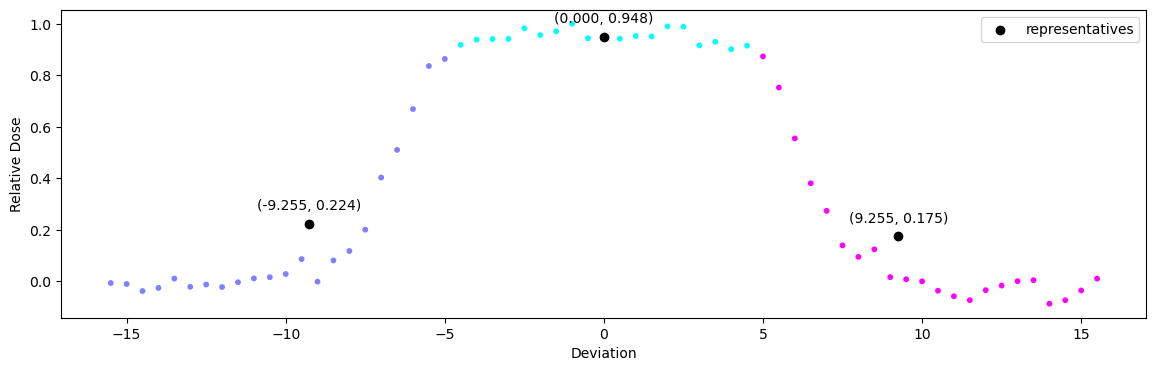

<Figure size 640x480 with 0 Axes>

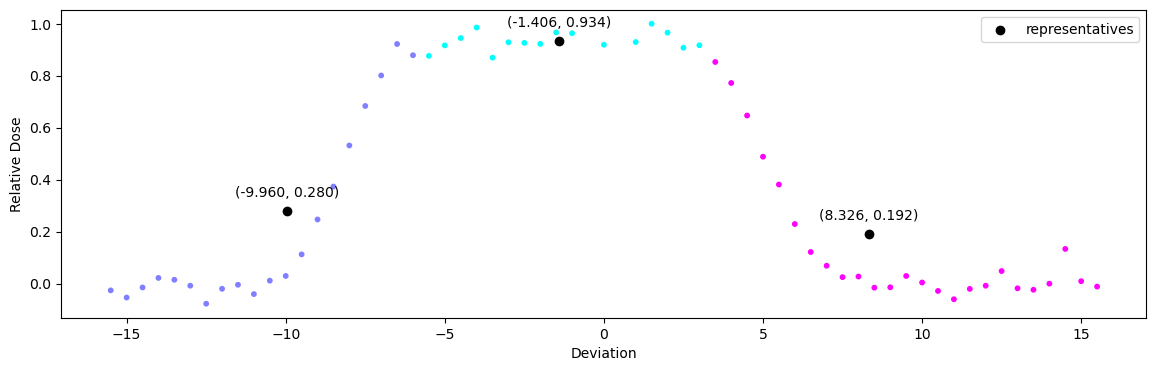

<Figure size 640x480 with 0 Axes>

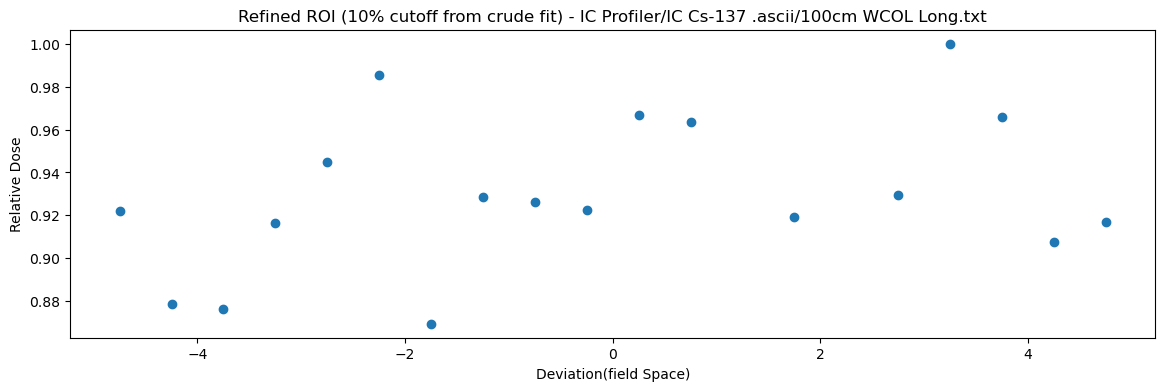

<Figure size 640x480 with 0 Axes>

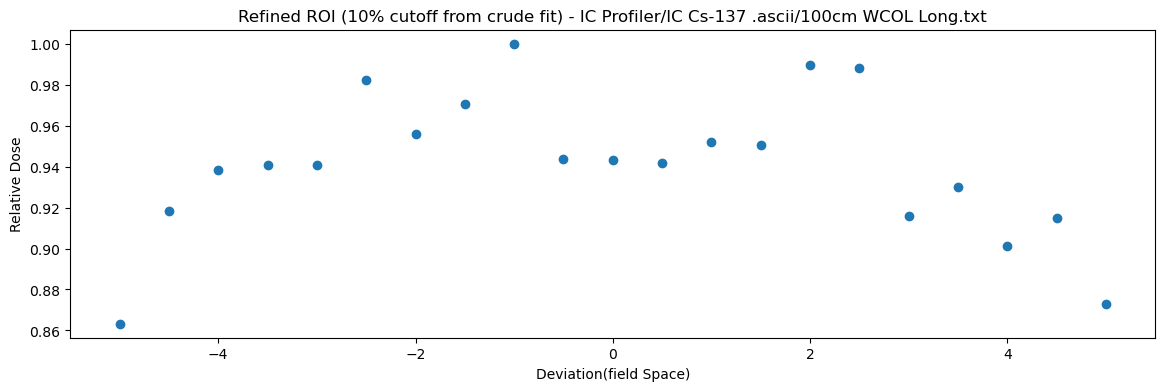

<Figure size 640x480 with 0 Axes>

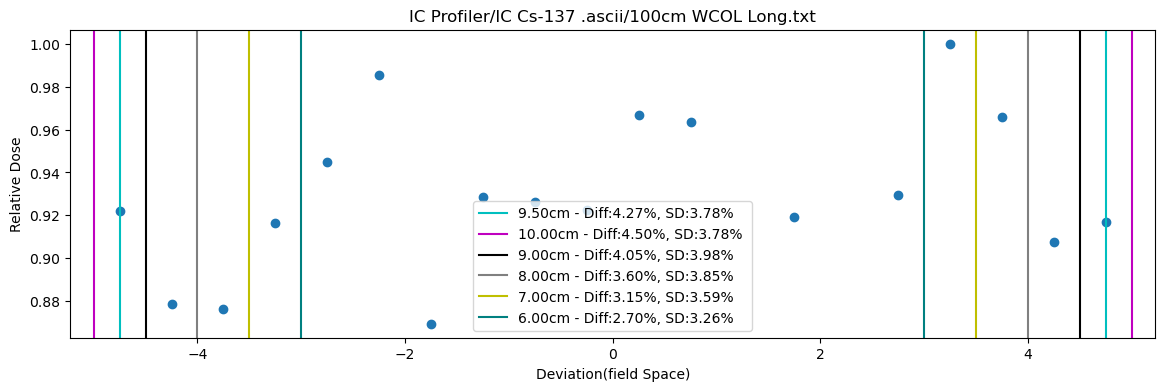

4.75cm: (0.922, 0.917)
5.00cm: (0.922, 0.917)
4.50cm: (0.922, 0.908)
4.00cm: (0.879, 0.966)
3.50cm: (0.876, 1.000)
3.00cm: (0.917, 0.929)
Shifted by -1.750cm V
------------------------------------------------------------------------------------------------------------------------
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
------------------------------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

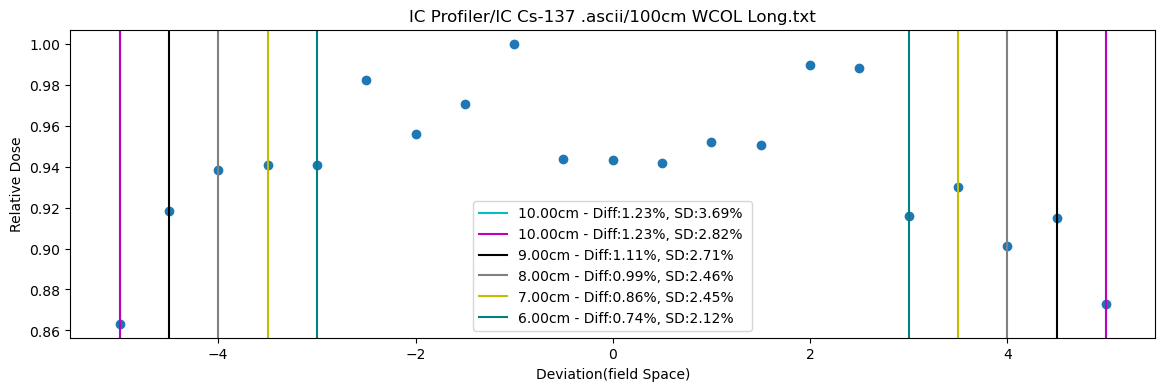

5.00cm: (0.863, 0.873)
5.00cm: (0.863, 0.873)
4.50cm: (0.918, 0.915)
4.00cm: (0.938, 0.901)
3.50cm: (0.941, 0.930)
3.00cm: (0.941, 0.916)
Shifted by 0.000cm H
------------------------------------------------------------------------------------------------------------------------
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
------------------------------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

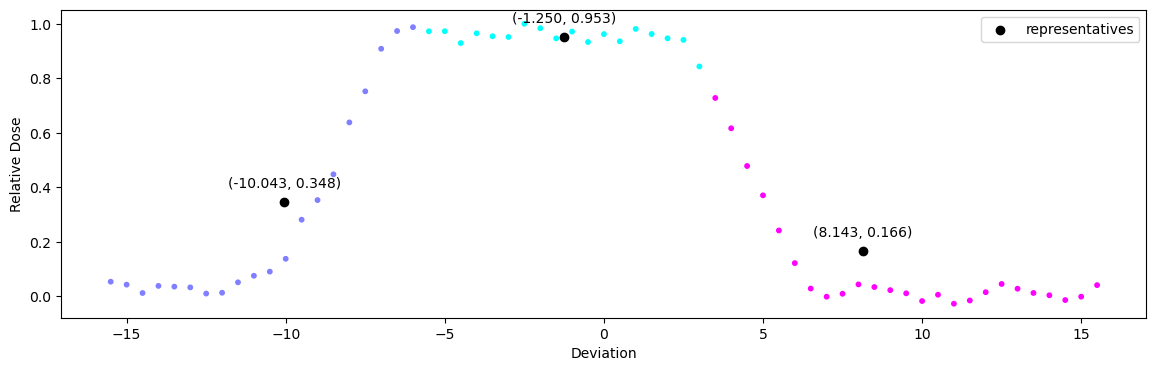

<Figure size 640x480 with 0 Axes>

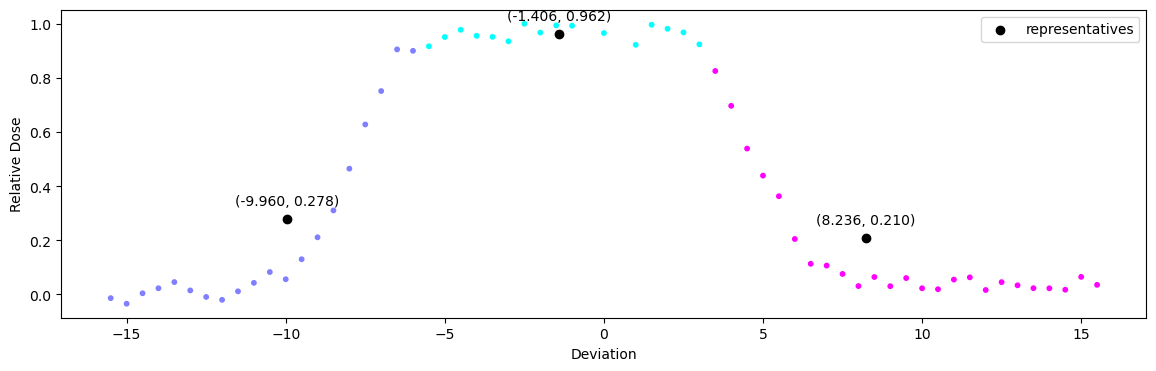

<Figure size 640x480 with 0 Axes>

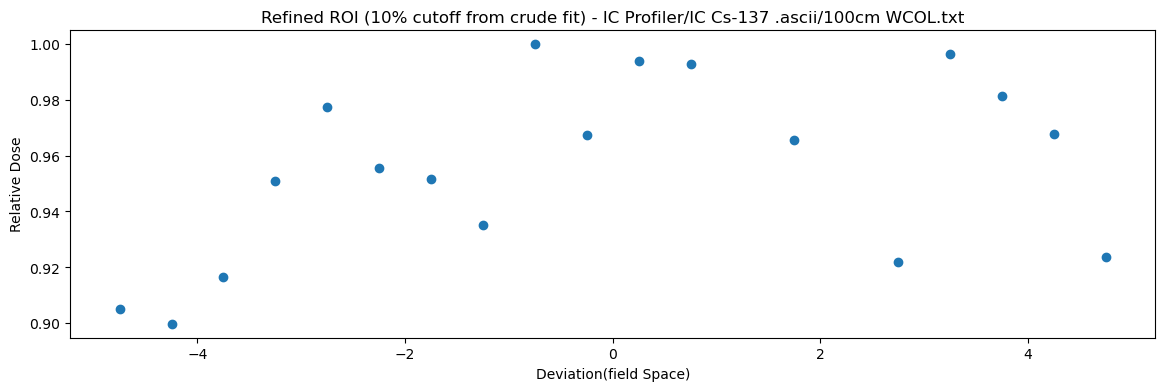

<Figure size 640x480 with 0 Axes>

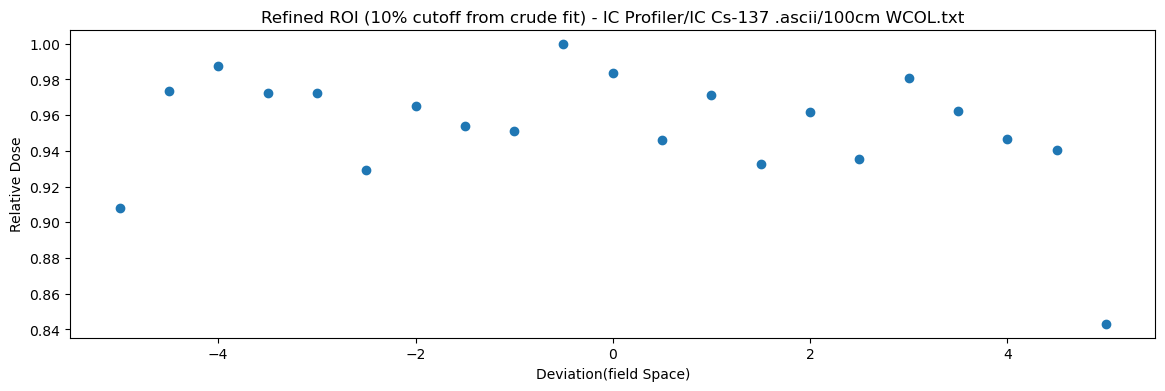

<Figure size 640x480 with 0 Axes>

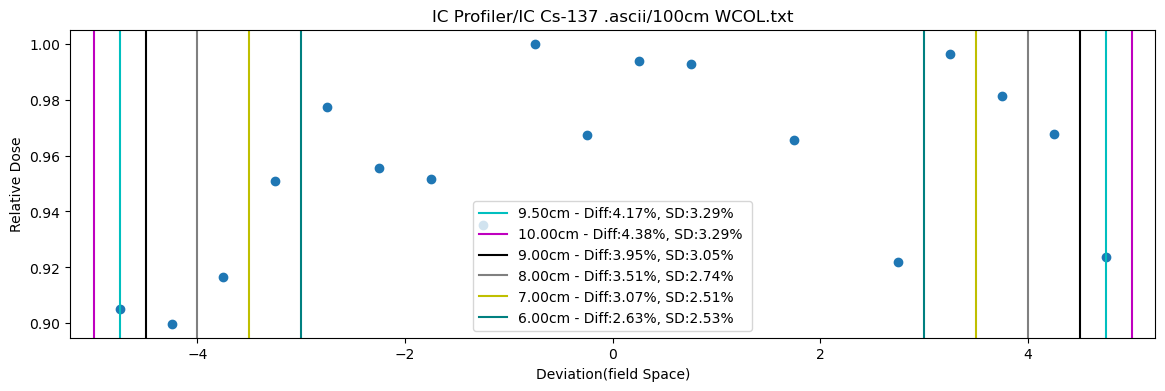

4.75cm: (0.905, 0.924)
5.00cm: (0.905, 0.924)
4.50cm: (0.905, 0.968)
4.00cm: (0.900, 0.981)
3.50cm: (0.917, 0.996)
3.00cm: (0.951, 0.922)
Shifted by -1.750cm V
------------------------------------------------------------------------------------------------------------------------
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
------------------------------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

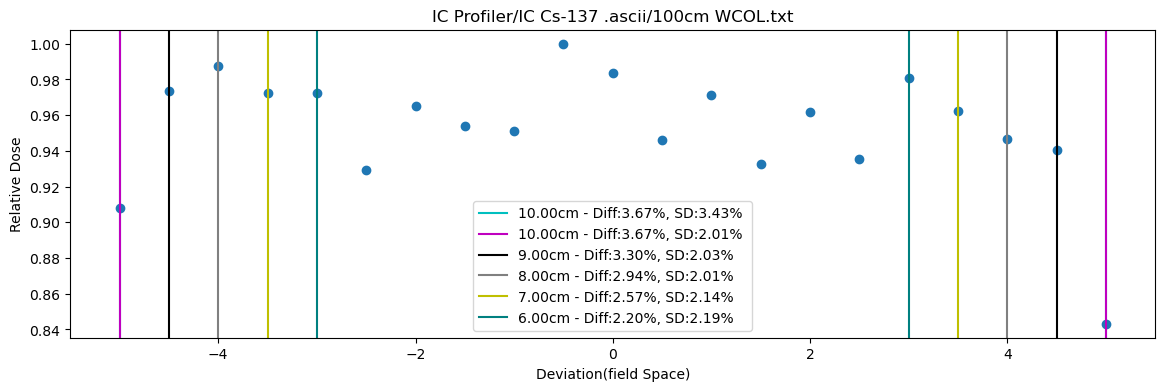

5.00cm: (0.908, 0.843)
5.00cm: (0.908, 0.843)
4.50cm: (0.973, 0.941)
4.00cm: (0.987, 0.946)
3.50cm: (0.972, 0.962)
3.00cm: (0.972, 0.981)
Shifted by -2.000cm H
------------------------------------------------------------------------------------------------------------------------
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
------------------------------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

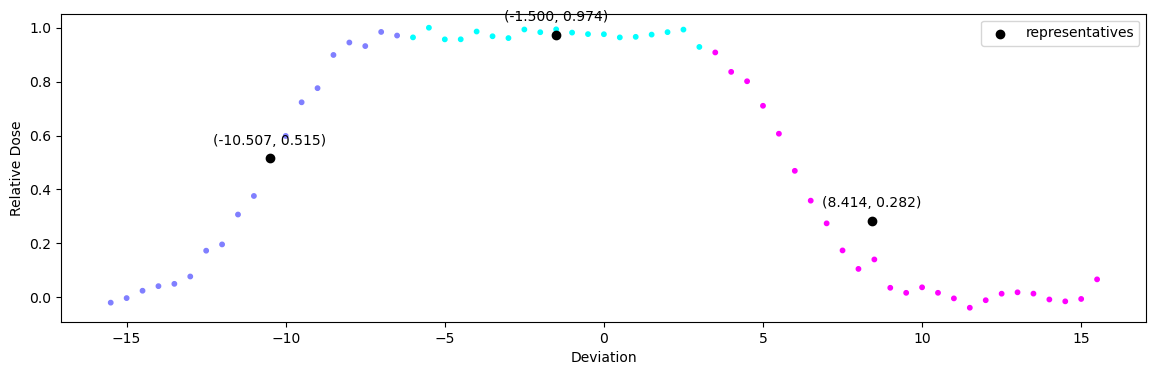

<Figure size 640x480 with 0 Axes>

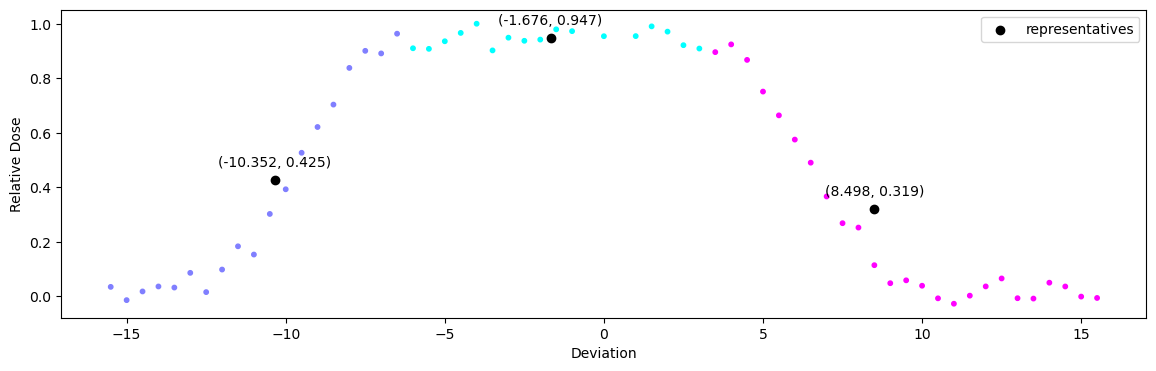

<Figure size 640x480 with 0 Axes>

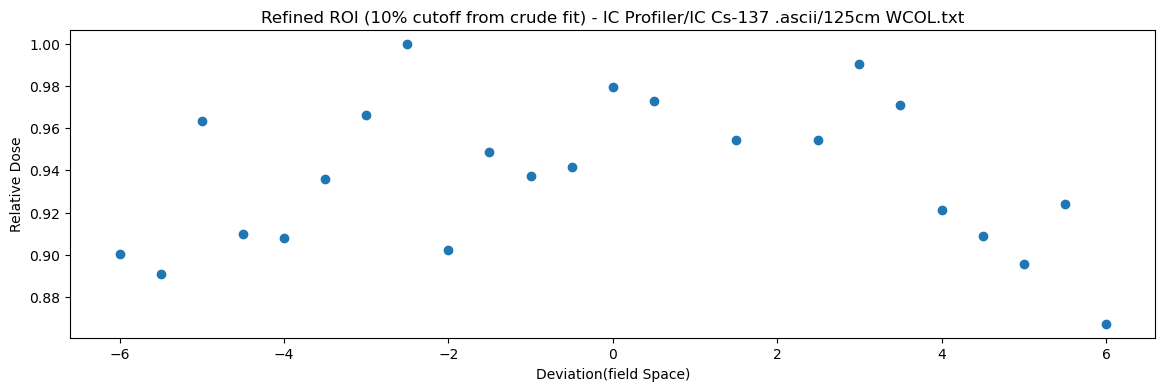

<Figure size 640x480 with 0 Axes>

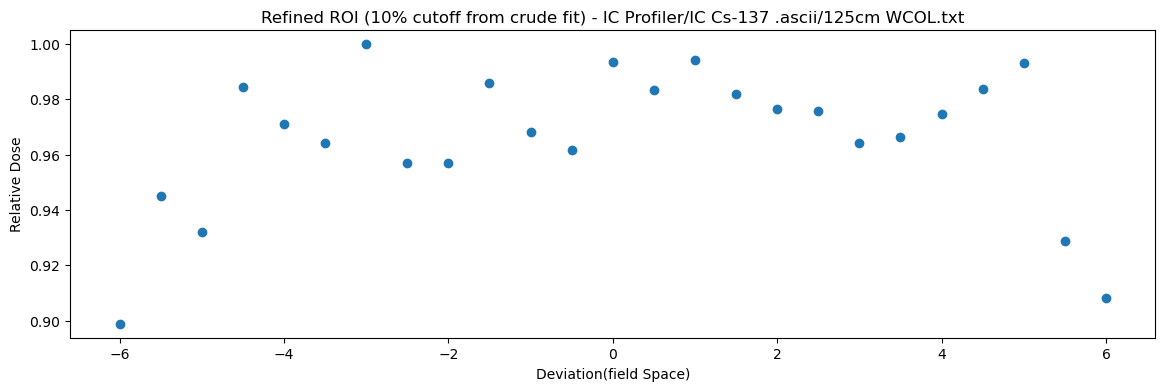

<Figure size 640x480 with 0 Axes>

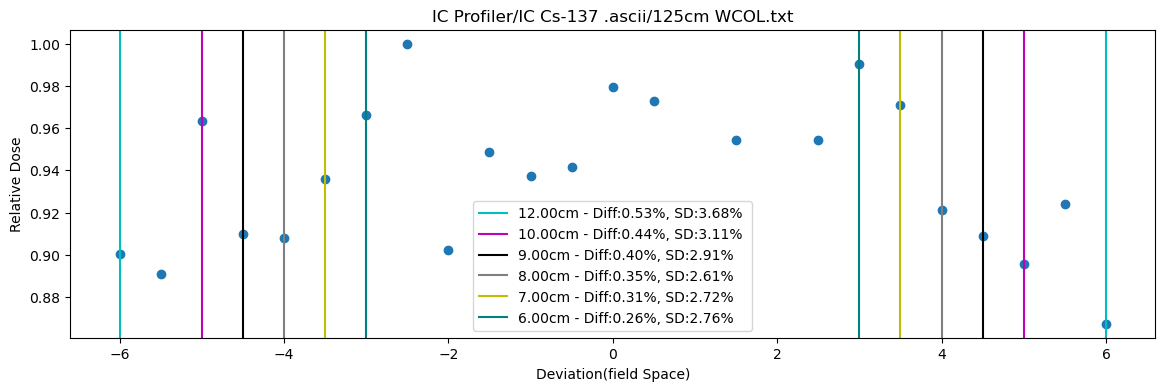

6.00cm: (0.901, 0.867)
5.00cm: (0.963, 0.896)
4.50cm: (0.910, 0.909)
4.00cm: (0.908, 0.921)
3.50cm: (0.936, 0.971)
3.00cm: (0.966, 0.990)
Shifted by -1.500cm V
------------------------------------------------------------------------------------------------------------------------
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
------------------------------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

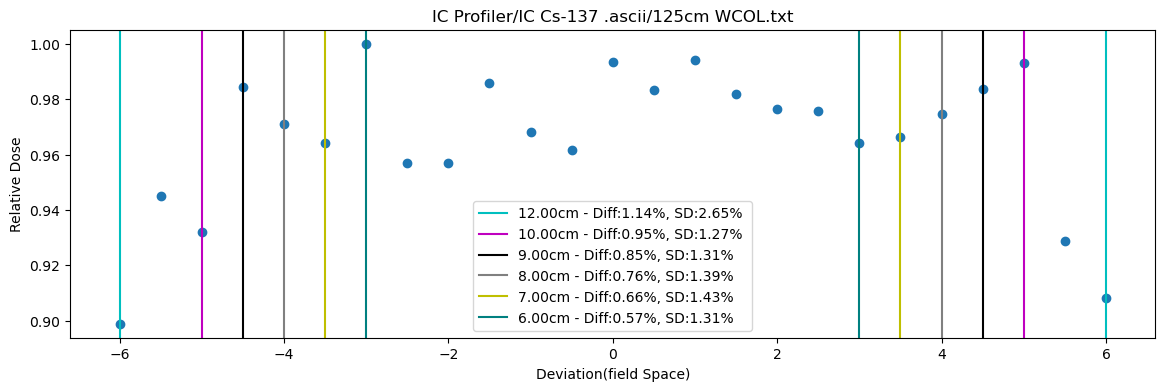

6.00cm: (0.899, 0.908)
5.00cm: (0.932, 0.993)
4.50cm: (0.984, 0.984)
4.00cm: (0.971, 0.975)
3.50cm: (0.964, 0.966)
3.00cm: (1.000, 0.964)
Shifted by -2.500cm H
------------------------------------------------------------------------------------------------------------------------
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
------------------------------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

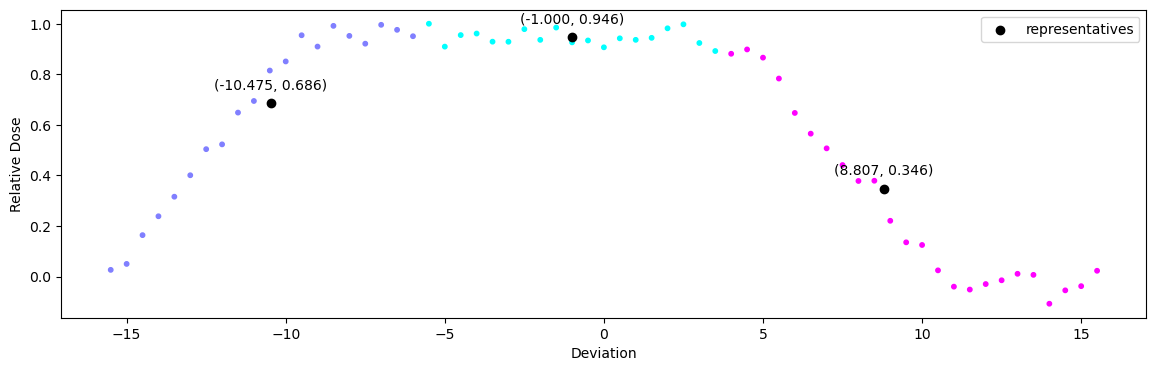

<Figure size 640x480 with 0 Axes>

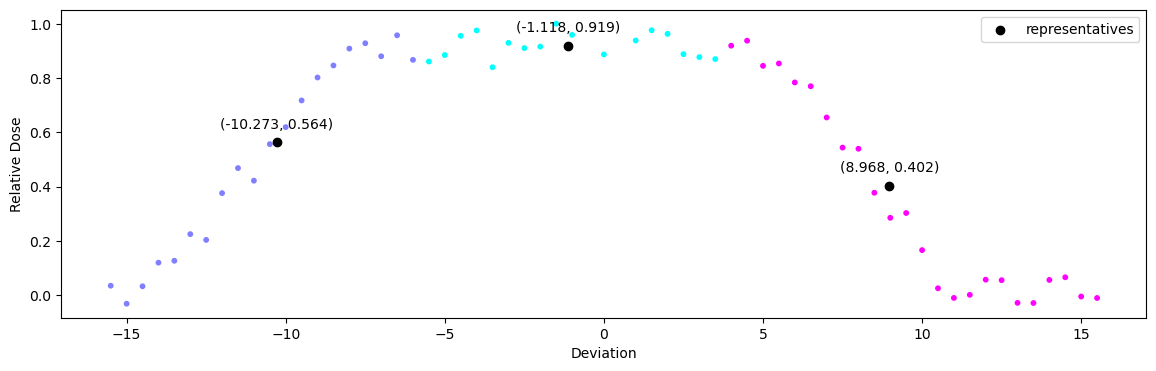

<Figure size 640x480 with 0 Axes>

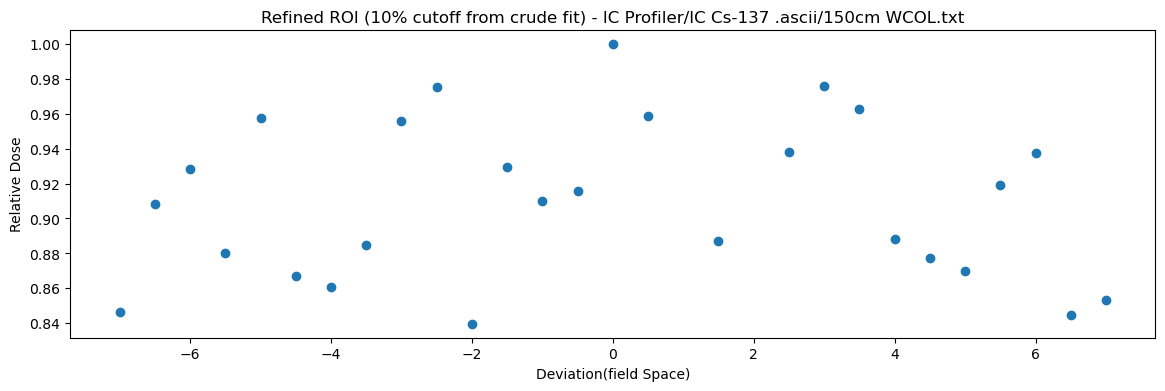

<Figure size 640x480 with 0 Axes>

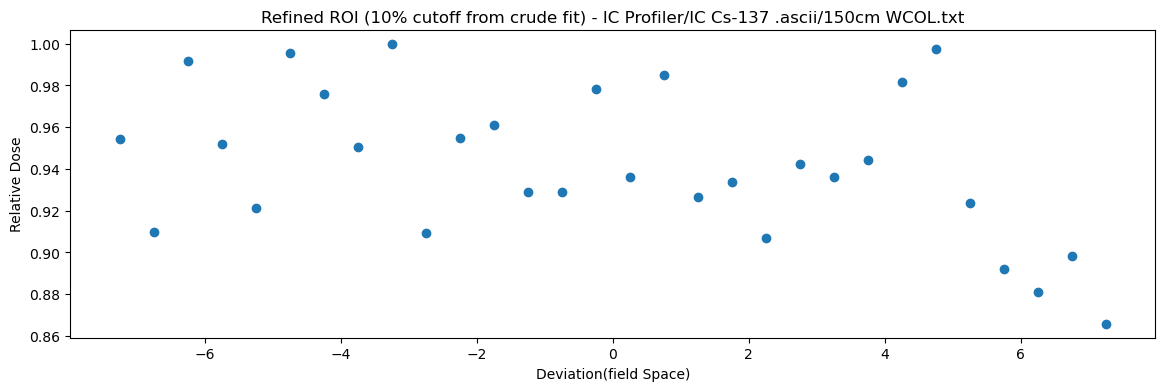

<Figure size 640x480 with 0 Axes>

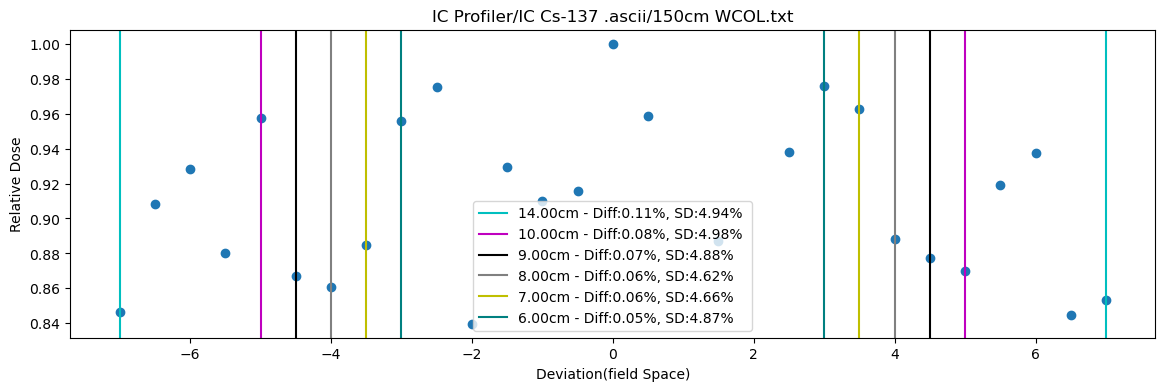

7.00cm: (0.846, 0.854)
5.00cm: (0.957, 0.870)
4.50cm: (0.867, 0.877)
4.00cm: (0.861, 0.888)
3.50cm: (0.885, 0.963)
3.00cm: (0.956, 0.976)
Shifted by -1.500cm V
------------------------------------------------------------------------------------------------------------------------
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
------------------------------------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

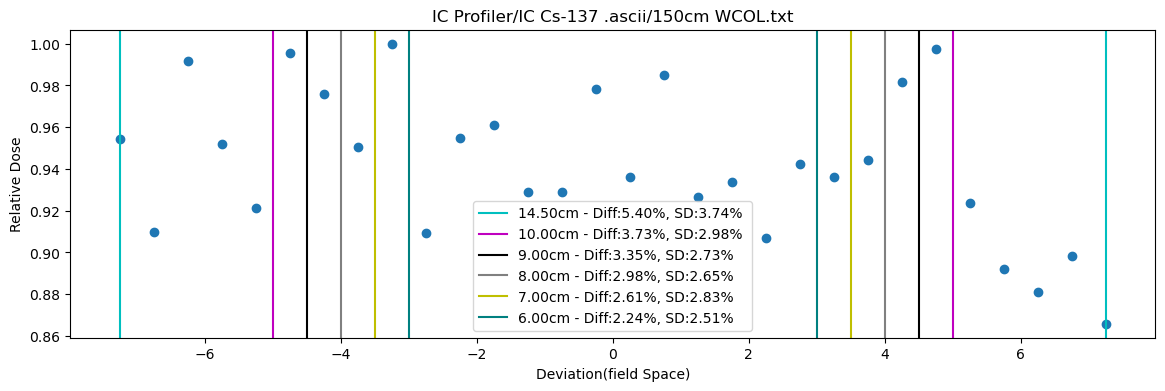

7.25cm: (0.954, 0.866)
5.00cm: (0.921, 0.998)
4.50cm: (0.996, 0.982)
4.00cm: (0.976, 0.944)
3.50cm: (0.951, 0.936)
3.00cm: (1.000, 0.942)
Shifted by -2.250cm H
------------------------------------------------------------------------------------------------------------------------
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
------------------------------------------------------------------------------------------------------------------------


In [16]:
cutoffs = [2,3,4]
for path in icpath_col_bad: 
    data = ic_extract(path)
    x = data['x_axis_measurements']
    y = data['y_axis_measurements']
    Hband = Band(path,x,'H')
    Vband = Band(path,y,'V')
    
    Vband.refine(10)
    Hband.refine(10)
    Vband.conc_plotter(show_conc = True)
    Hband.conc_plotter(show_conc = True)